In [1]:
import pandas as pd
import numpy as np
import _pickle

In [2]:
import matplotlib.pyplot as plt

In [3]:
from multiple_initializations import BettingOptimizer

In [4]:
class Simulation(object):
    def __init__(self, prediction_df):
        prediction_df['cv_pred_label'] = prediction_df['cv_pred'] >= 0.5
        prediction_df['correct'] = prediction_df['TEAM_A_WIN'] == prediction_df['cv_pred_label']
        
        prediction_df['odds'] = prediction_df['home_odds']
        idx = prediction_df[~prediction_df['cv_pred_label']].index
        prediction_df.loc[idx, 'odds'] = prediction_df.loc[idx, 'away_odds']
        
        prediction_df['proba'] = np.abs(prediction_df['cv_pred'] - 0.5) + 0.5
        
        prediction_df['bet_ratio'] = None
        self.df = prediction_df
        
        self.rounds = self.df.groupby('GAME_DATE')
        self.round_dates = list(self.rounds.groups.keys())
        self.round_results = {'headers': ['sharpe_ratio', 'rate_of_return'],
                              'rounds':{}}
        
    def optimize(self, log=False):
        i = 0
        for round_date in self.round_dates:
            
            round_games = self.rounds.get_group(round_date)
            probs = list(round_games['proba'])
            odds = list(round_games['odds'].astype('float'))
            if log: 
                print(i)
                print(probs)
                print(odds)
                print()
            
            optimizer = BettingOptimizer(probs=probs, odds=odds, num_inits=10)
            ratios, sharpe = optimizer.run()
           
            self.df.loc[round_games.index, 'bet_ratio'] = ratios
            
            ror = np.sum(round_games['correct'] * round_games['odds'].astype('float') * ratios) - 1
            self.round_results['rounds'][round_date] = [sharpe, ror]
          
            i += 1
            
    def results_to_dataframe(self):
        results_df = pd.DataFrame(self.round_results['rounds']).transpose()
        results_df.rename(columns={0:self.round_results['headers'][0], 1:self.round_results['headers'][1]}, inplace=True)
        
        idx = results_df[results_df['sharpe_ratio']==-10000].index
        results_df.loc[idx, 'rate_of_return'] = 0
        return results_df
            
#     def back_test(self, min_sharpe):
        

In [5]:
with open('predictions_df', 'rb') as f:
    preds = _pickle.load(f)
preds

,GAME_ID,GAME_DATE,SEASON_ID,home_team,away_team,TEAM_A_WIN,cv_pred,home_odds,away_odds
10244,0021800687,2019-01-19,22018,Denver Nuggets,Cleveland Cavaliers,True,0.916291,1.04,16.87
10245,0021800686,2019-01-19,22018,Houston Rockets,Los Angeles Lakers,True,0.669081,1.35,3.49
10246,0021800680,2019-01-19,22018,Detroit Pistons,Sacramento Kings,False,0.559464,1.98,1.93
10247,0021800684,2019-01-19,22018,Toronto Raptors,Memphis Grizzlies,True,0.845801,1.17,5.94
10248,0021800681,2019-01-19,22018,Indiana Pacers,Dallas Mavericks,True,0.683076,1.34,3.63
...,...,...,...,...,...,...,...,...,...
14481,0022200839,2023-02-10,22022,Toronto Raptors,Utah Jazz,False,0.774376,1.33,4.58
14482,0022200836,2023-02-10,22022,Indiana Pacers,Phoenix Suns,False,0.442533,2.10,2.30
14483,0022200843,2023-02-10,22022,Portland Trail Blazers,Oklahoma City Thunder,False,0.733281,1.80,2.35
14484,0022200844,2023-02-10,22022,Sacramento Kings,Dallas Mavericks,False,0.686340,1.75,2.80


In [6]:
from time import time

In [7]:
simulation = Simulation(preds)

In [8]:
t0 = time()
simulation.optimize()
time() - t0

316.0153992176056

In [9]:
results_df = simulation.results_to_dataframe()

In [10]:
results_df

,sharpe_ratio,rate_of_return
2019-01-19,0.109604,-1.000000
2019-01-20,0.054135,-0.165000
2019-01-21,0.361217,-0.425005
2019-01-22,0.041161,0.580000
2019-01-23,0.415878,-0.102113
...,...,...
2023-02-06,0.664153,0.394308
2023-02-07,2.926841,0.949485
2023-02-08,0.312993,-0.058435
2023-02-09,0.515381,0.434336


In [11]:
idx = results_df[results_df['sharpe_ratio']==-10000].index
results_df.drop(idx, inplace=True)

In [12]:
results_df

,sharpe_ratio,rate_of_return
2019-01-19,0.109604,-1.000000
2019-01-20,0.054135,-0.165000
2019-01-21,0.361217,-0.425005
2019-01-22,0.041161,0.580000
2019-01-23,0.415878,-0.102113
...,...,...
2023-02-06,0.664153,0.394308
2023-02-07,2.926841,0.949485
2023-02-08,0.312993,-0.058435
2023-02-09,0.515381,0.434336


# relationship between sharpe ratio and  ror

In [13]:
results_df.describe()

,sharpe_ratio,rate_of_return
count,309.000000,309.000000
mean,0.472740,-0.039630
std,0.459561,0.629683
min,0.007127,-1.000000
25%,0.237363,-0.590832
50%,0.367977,0.056553
75%,0.552511,0.421845
max,4.298337,2.257097


<AxesSubplot:>

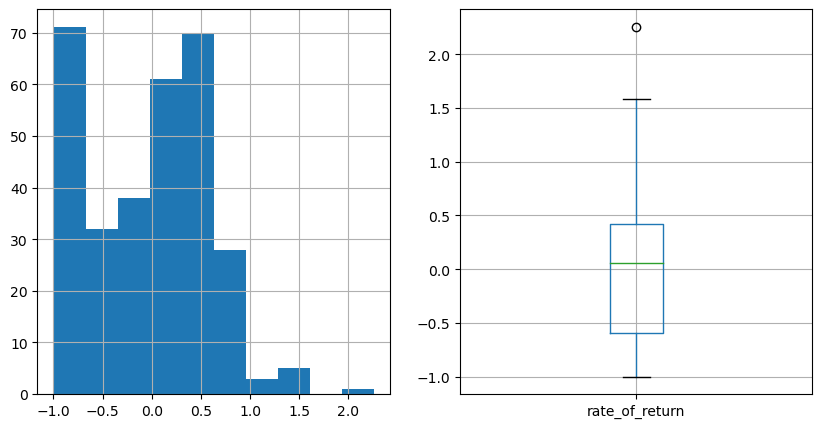

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

results_df['rate_of_return'].hist(ax=ax[0])
results_df.boxplot('rate_of_return', ax=ax[1])

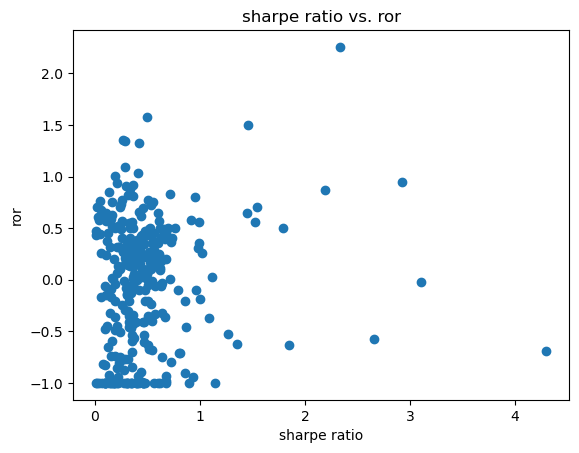

In [15]:
plt.scatter(results_df['sharpe_ratio'], results_df['rate_of_return'])
plt.xlabel('sharpe ratio')
plt.ylabel('ror')
plt.title('sharpe ratio vs. ror')
plt.show()

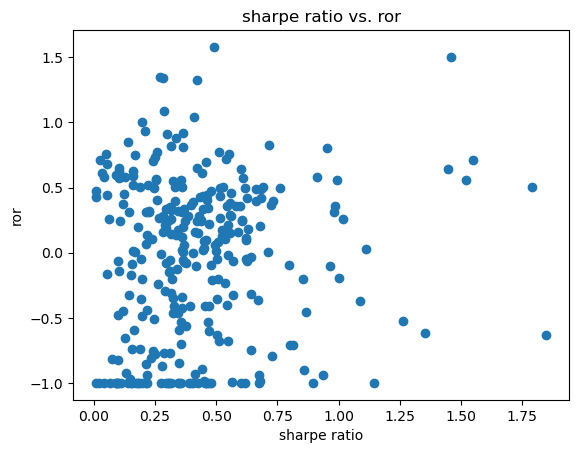

In [16]:
mask = results_df['sharpe_ratio'] <= 2
plt.scatter(results_df[mask]['sharpe_ratio'], results_df[mask]['rate_of_return'])
plt.xlabel('sharpe ratio')
plt.ylabel('ror')
plt.title('sharpe ratio vs. ror')
plt.show()

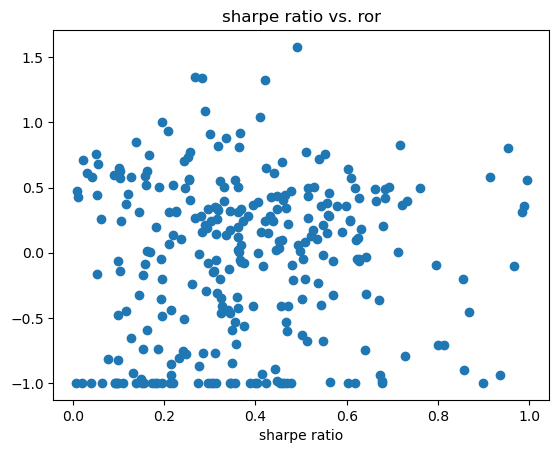

In [17]:
mask = results_df['sharpe_ratio'] <= 1
plt.scatter(results_df[mask]['sharpe_ratio'], results_df[mask]['rate_of_return'])
plt.xlabel('sharpe ratio')
plt.title('sharpe ratio vs. ror')
plt.show()

In [18]:
results_df.corr()

,sharpe_ratio,rate_of_return
sharpe_ratio,1.000000,0.104013
rate_of_return,0.104013,1.000000


Contrary to what is expected, there appears to be no significant correlation between the sharpe ratios and the rates of return. In addition to the possibility of the weakness of the prediction model or the portfolio optimization algorithm, the reason behind this may be the small number of games in a betting batch or low confidence of the games predicted.

# relation between number of games played and ror

In [19]:
simulation.df

,GAME_ID,GAME_DATE,SEASON_ID,home_team,away_team,TEAM_A_WIN,cv_pred,home_odds,away_odds,cv_pred_label,correct,odds,proba,bet_ratio
10244,0021800687,2019-01-19,22018,Denver Nuggets,Cleveland Cavaliers,True,0.916291,1.04,16.87,True,True,1.04,0.916291,0.0
10245,0021800686,2019-01-19,22018,Houston Rockets,Los Angeles Lakers,True,0.669081,1.35,3.49,True,True,1.35,0.669081,0.0
10246,0021800680,2019-01-19,22018,Detroit Pistons,Sacramento Kings,False,0.559464,1.98,1.93,True,False,1.98,0.559464,1.0
10247,0021800684,2019-01-19,22018,Toronto Raptors,Memphis Grizzlies,True,0.845801,1.17,5.94,True,True,1.17,0.845801,0.0
10248,0021800681,2019-01-19,22018,Indiana Pacers,Dallas Mavericks,True,0.683076,1.34,3.63,True,True,1.34,0.683076,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14481,0022200839,2023-02-10,22022,Toronto Raptors,Utah Jazz,False,0.774376,1.33,4.58,True,False,1.33,0.774376,0.0
14482,0022200836,2023-02-10,22022,Indiana Pacers,Phoenix Suns,False,0.442533,2.10,2.30,False,True,2.30,0.557467,0.043165
14483,0022200843,2023-02-10,22022,Portland Trail Blazers,Oklahoma City Thunder,False,0.733281,1.80,2.35,True,False,1.80,0.733281,0.080933
14484,0022200844,2023-02-10,22022,Sacramento Kings,Dallas Mavericks,False,0.686340,1.75,2.80,True,False,1.75,0.686340,0.050909


In [20]:
simulation.rounds.get_group('2019-01-20')

,GAME_ID,GAME_DATE,SEASON_ID,home_team,away_team,TEAM_A_WIN,cv_pred,home_odds,away_odds,cv_pred_label,correct,odds,proba,bet_ratio
10252,0021800689,2019-01-20,22018,Minnesota Timberwolves,Phoenix Suns,True,0.722924,1.11,8.26,True,True,1.11,0.722924,0.0
10253,0021800690,2019-01-20,22018,San Antonio Spurs,Los Angeles Clippers,False,0.828545,1.22,4.85,True,False,1.22,0.828545,0.357693
10254,0021800688,2019-01-20,22018,Indiana Pacers,Charlotte Hornets,True,0.789117,1.30,3.92,True,True,1.30,0.789117,0.642307


In [21]:
def get_n_games_and_n_played(rounds, game_date):
    round_info = rounds.get_group(game_date)
    n_games = len(round_info)
    n_played = np.sum(round_info['bet_ratio'] > 0)
    return n_games, n_played

In [22]:
get_n_games_and_n_played(simulation.rounds, '2019-01-20')

(3, 2)

In [23]:
results_df['game_counts'] = results_df.index.to_series().apply(lambda x:get_n_games_and_n_played(simulation.rounds, x))
results_df[['n_games', 'n_played']] = results_df['game_counts'].apply(lambda x: pd.Series([x[0], x[1]]))
results_df.drop('game_counts', axis=1, inplace=True)

In [24]:
results_df

,sharpe_ratio,rate_of_return,n_games,n_played
2019-01-19,0.109604,-1.000000,8,1
2019-01-20,0.054135,-0.165000,3,2
2019-01-21,0.361217,-0.425005,11,5
2019-01-22,0.041161,0.580000,4,1
2019-01-23,0.415878,-0.102113,10,5
...,...,...,...,...
2023-02-06,0.664153,0.394308,7,6
2023-02-07,2.926841,0.949485,6,2
2023-02-08,0.312993,-0.058435,10,4
2023-02-09,0.515381,0.434336,4,3


In [25]:
results_df.corr()

,sharpe_ratio,rate_of_return,n_games,n_played
sharpe_ratio,1.000000,0.104013,0.182441,0.391240
rate_of_return,0.104013,1.000000,-0.085262,0.109093
n_games,0.182441,-0.085262,1.000000,0.534579
n_played,0.391240,0.109093,0.534579,1.000000


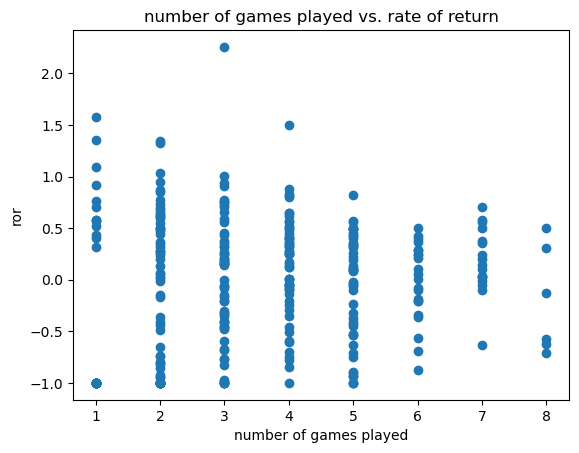

In [26]:
plt.scatter(results_df['n_played'], results_df['rate_of_return'])
plt.xlabel('number of games played')
plt.ylabel('ror')
plt.title('number of games played vs. rate of return')
plt.show()

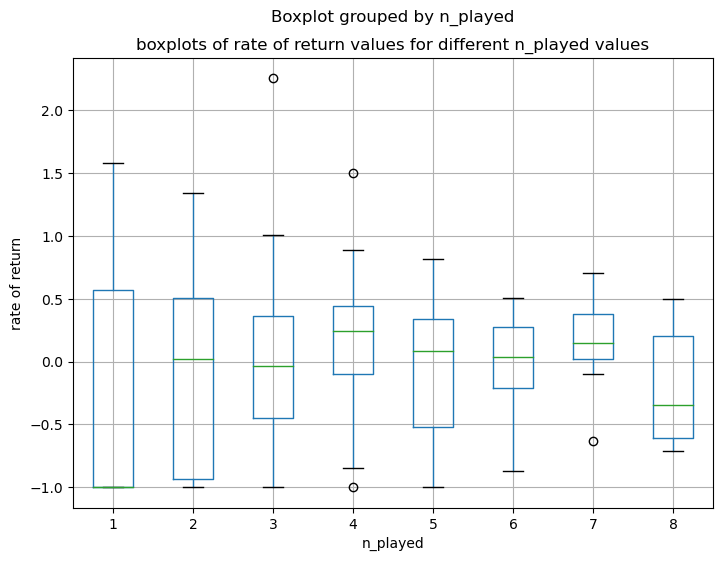

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
results_df.boxplot(column=['rate_of_return'], by='n_played', ax=ax)

ax.set_title('boxplots of rate of return values for different n_played values')
ax.set_ylabel('rate of return')
plt.show()

In [28]:
results_df.groupby('n_played').agg({'rate_of_return':['mean', 'std', 'count']})

rate_of_return                
                   mean       std count
n_played                               
1             -0.287187  0.907162    32
2             -0.110413  0.733602    66
3             -0.008922  0.636521    60
4              0.132510  0.493335    57
5             -0.085514  0.519572    49
6             -0.020758  0.378250    22
7              0.181082  0.322768    17
8             -0.202924  0.515817     6

As expected, there is a tendency towards a lower standard deviation as the number of games the portfolio optimization algorithm chooses to bet in. It might be reasonable to try different thresholds for n_played to optimize the algorithm.

In [29]:
# interaction column
results_df['INT_sharpe_n_played'] = results_df['sharpe_ratio'] * results_df['n_played']

In [30]:
results_df.corr()

,sharpe_ratio,rate_of_return,n_games,n_played,INT_sharpe_n_played
sharpe_ratio,1.000000,0.104013,0.182441,0.391240,0.897985
rate_of_return,0.104013,1.000000,-0.085262,0.109093,0.062813
n_games,0.182441,-0.085262,1.000000,0.534579,0.294086
n_played,0.391240,0.109093,0.534579,1.000000,0.616575
INT_sharpe_n_played,0.897985,0.062813,0.294086,0.616575,1.000000


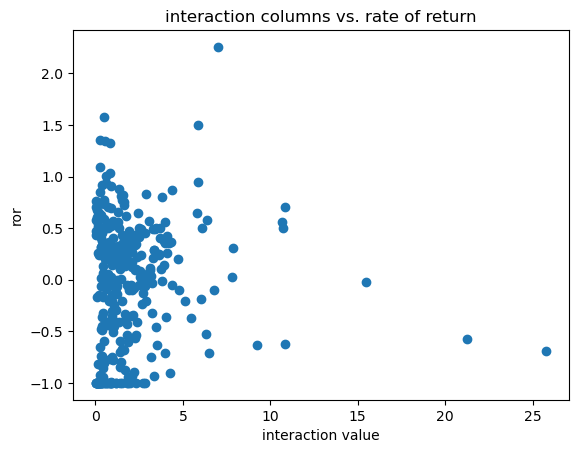

In [31]:
plt.scatter(results_df['INT_sharpe_n_played'], results_df['rate_of_return'])
plt.xlabel('interaction value')
plt.ylabel('ror')
plt.title('interaction columns vs. rate of return')
plt.show()

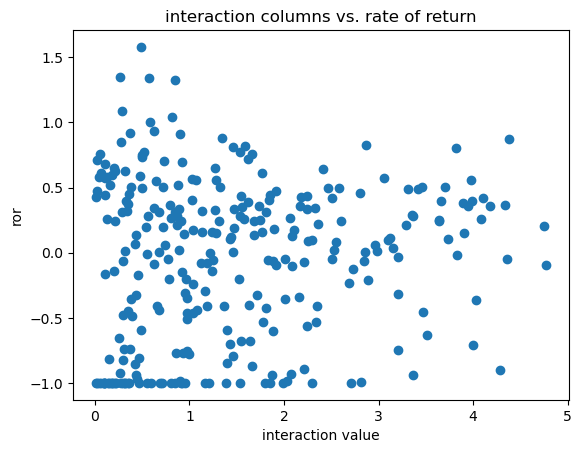

In [32]:
mask = results_df['INT_sharpe_n_played'] < 5

plt.scatter(results_df[mask]['INT_sharpe_n_played'], results_df[mask]['rate_of_return'])
plt.xlabel('interaction value')
plt.ylabel('ror')
plt.title('interaction columns vs. rate of return')
plt.show()

The interaction term doesn't seem to be helpful either. 

# confidence thresholding

In [33]:
conf_threshold_df = simulation.df[['correct', 'proba', 'odds', 'bet_ratio']].astype('float').copy()
conf_threshold_df['bookmaker_proba'] = 1/conf_threshold_df['odds']
conf_threshold_df['bookmaker_proba'] = np.abs(conf_threshold_df['bookmaker_proba'] - 0.5) + 0.5
conf_threshold_df['ror'] = conf_threshold_df['bet_ratio'] * (conf_threshold_df['correct']*conf_threshold_df['odds'] - 1)
conf_threshold_df.rename(columns={'proba':'model_confidence', 'bookmaker_proba':'bookmaker_confidence'}, inplace=True)
conf_threshold_df

,correct,model_confidence,odds,bet_ratio,bookmaker_confidence,ror
10244,1.0,0.916291,1.04,0.000000,0.961538,0.000000
10245,1.0,0.669081,1.35,0.000000,0.740741,0.000000
10246,0.0,0.559464,1.98,1.000000,0.505051,-1.000000
10247,1.0,0.845801,1.17,0.000000,0.854701,0.000000
10248,1.0,0.683076,1.34,0.000000,0.746269,0.000000
...,...,...,...,...,...,...
14481,0.0,0.774376,1.33,0.000000,0.751880,-0.000000
14482,1.0,0.557467,2.30,0.043165,0.565217,0.056115
14483,0.0,0.733281,1.80,0.080933,0.555556,-0.080933
14484,0.0,0.686340,1.75,0.050909,0.571429,-0.050909


In [34]:
conf_threshold_df.corr()

,correct,model_confidence,odds,bet_ratio,bookmaker_confidence,ror
correct,1.000000,0.180031,-0.230339,-0.096018,0.255759,0.487516
model_confidence,0.180031,1.000000,-0.480624,0.255933,0.644096,0.023901
odds,-0.230339,-0.480624,1.000000,0.278126,-0.654102,-0.016048
bet_ratio,-0.096018,0.255933,0.278126,1.000000,-0.249592,-0.080526
bookmaker_confidence,0.255759,0.644096,-0.654102,-0.249592,1.000000,0.028830
ror,0.487516,0.023901,-0.016048,-0.080526,0.028830,1.000000


The absence of correlation between model confidence and profit is the most probably because the correlation between model and bookmaker confidences. When model predicts an outcome, in general, the prediction of the bookmaker is the same. This makes it hard for the model to spot the underdog.

<AxesSubplot:>

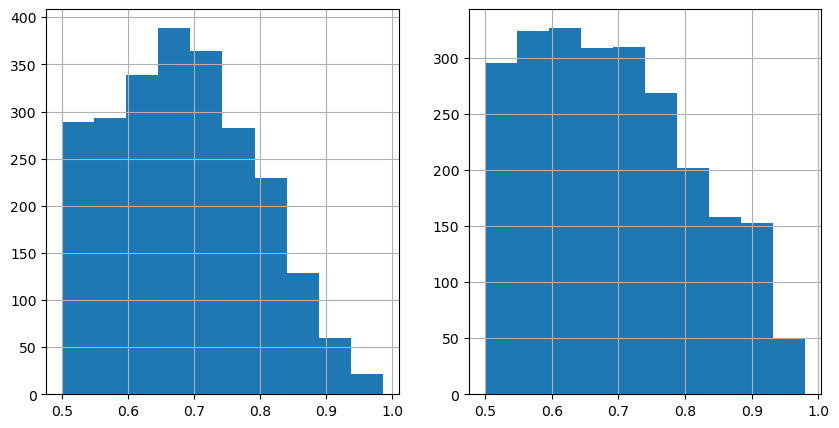

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

conf_threshold_df['model_confidence'].hist(ax=ax[0])
conf_threshold_df['bookmaker_confidence'].hist(ax=ax[1])

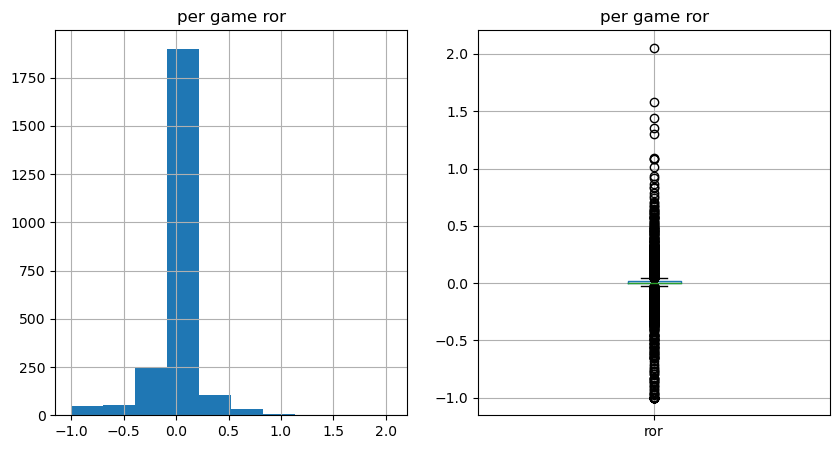

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

conf_threshold_df['ror'].hist(ax=ax[0])
ax[0].set_title('per game ror')
conf_threshold_df.boxplot('ror', ax=ax[1])
ax[1].set_title('per game ror')
plt.show()

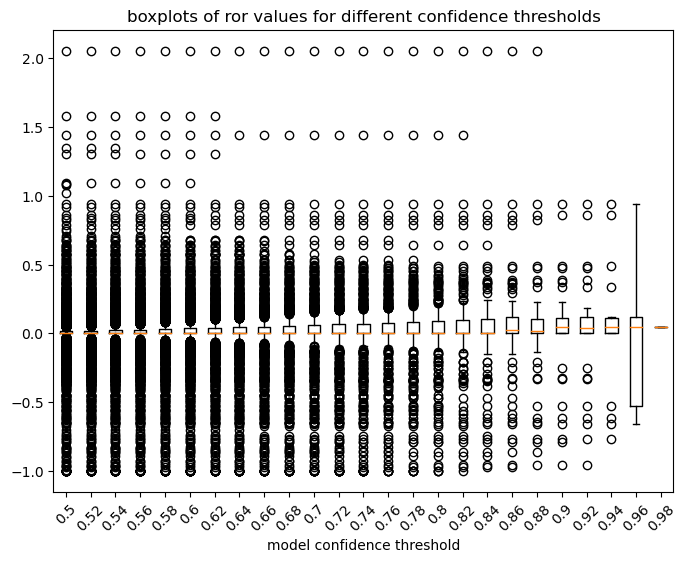

In [37]:
data = []
threshold_grid = [np.round(0.5 + 0.02*i, 2) for i in range(25)]
for threshold in threshold_grid:
    mask = conf_threshold_df['model_confidence'] > threshold
    data.append(conf_threshold_df[mask]['ror'])

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(data, labels=threshold_grid)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('model confidence threshold')
ax.set_title('boxplots of ror values for different confidence thresholds')
plt.show()

As can be seen, the per game rate of return values are quite messy and confidence thresholding provided a very slight impact. This makes it relatively unreasonable to try confidence thresholding before optimization as the method seems to be unpromising.

# prediction intervals for the rate of return

In [38]:
results_df

,sharpe_ratio,rate_of_return,n_games,n_played,INT_sharpe_n_played
2019-01-19,0.109604,-1.000000,8,1,0.109604
2019-01-20,0.054135,-0.165000,3,2,0.108270
2019-01-21,0.361217,-0.425005,11,5,1.806086
2019-01-22,0.041161,0.580000,4,1,0.041161
2019-01-23,0.415878,-0.102113,10,5,2.079388
...,...,...,...,...,...
2023-02-06,0.664153,0.394308,7,6,3.984921
2023-02-07,2.926841,0.949485,6,2,5.853681
2023-02-08,0.312993,-0.058435,10,4,1.251973
2023-02-09,0.515381,0.434336,4,3,1.546142


In [97]:
def get_expected_and_std_ror(rounds, game_date):
    round_info = rounds.get_group(game_date)
    expected_ror = np.sum((round_info['proba'] * round_info['odds'].astype('float') - 1) * round_info['bet_ratio'])
    std_ror = np.sqrt(np.sum((np.ones(len(round_info)) - round_info['proba']) * round_info['proba'] * np.square(round_info['bet_ratio']) * np.square(round_info['odds'].astype('float'))))
    return expected_ror, std_ror

In [98]:
results_df['e_std'] = results_df.index.to_series().apply(lambda x:get_expected_and_std_ror(simulation.rounds, x))
results_df[['expected_ror', 'std_ror']] = results_df['e_std'].apply(lambda x: pd.Series([x[0], x[1]]))
results_df.drop('e_std', axis=1, inplace=True)

In [99]:
results_df

,sharpe_ratio,rate_of_return,n_games,n_played,INT_sharpe_n_played,expected_ror,std_ror,dof,t_0.9,lower_0.9,upper_0.9
2019-01-19,0.109604,-1.000000,8,1,0.109604,0.107738,0.982974,7,1.894579,-1.000000,2.064746
2019-01-20,0.054135,-0.165000,3,2,0.108270,0.020477,0.378257,2,2.919986,-0.491206,0.532160
2019-01-21,0.361217,-0.425005,11,5,1.806086,0.179308,0.496399,10,1.812461,-0.289103,0.647718
2019-01-22,0.041161,0.580000,4,1,0.041161,0.030967,0.752353,3,2.353363,-1.000000,1.569127
2019-01-23,0.415878,-0.102113,10,5,2.079388,0.174792,0.420297,9,1.833113,-0.166543,0.516127
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06,0.664153,0.394308,7,6,3.984921,0.153177,0.230635,6,1.943180,0.041533,0.264822
2023-02-07,2.926841,0.949485,6,2,5.853681,0.889960,0.304069,5,2.015048,0.685871,1.094049
2023-02-08,0.312993,-0.058435,10,4,1.251973,0.125319,0.400389,9,1.833113,-0.184446,0.435085
2023-02-09,0.515381,0.434336,4,3,1.546142,0.248446,0.482063,3,2.353363,-0.383044,0.879936


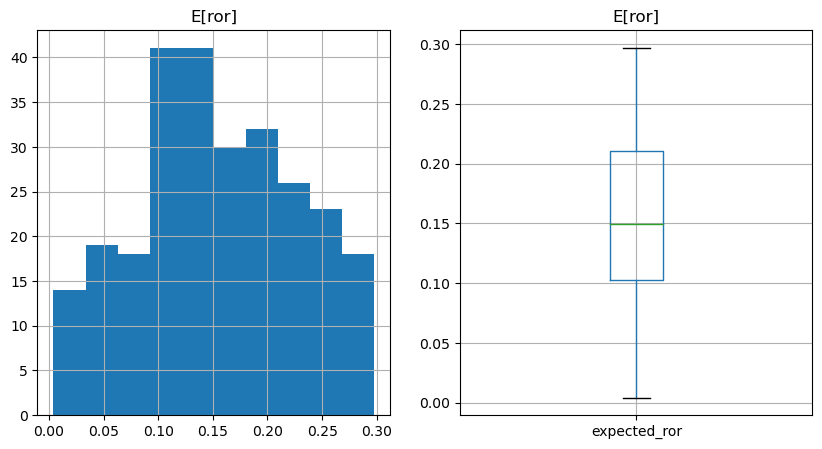

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

mask = results_df['expected_ror'] < 0.3
results_df[mask]['expected_ror'].hist(ax=ax[0])
ax[0].set_title('E[ror]')
results_df[mask].boxplot('expected_ror', ax=ax[1])
ax[1].set_title('E[ror]')
plt.show()

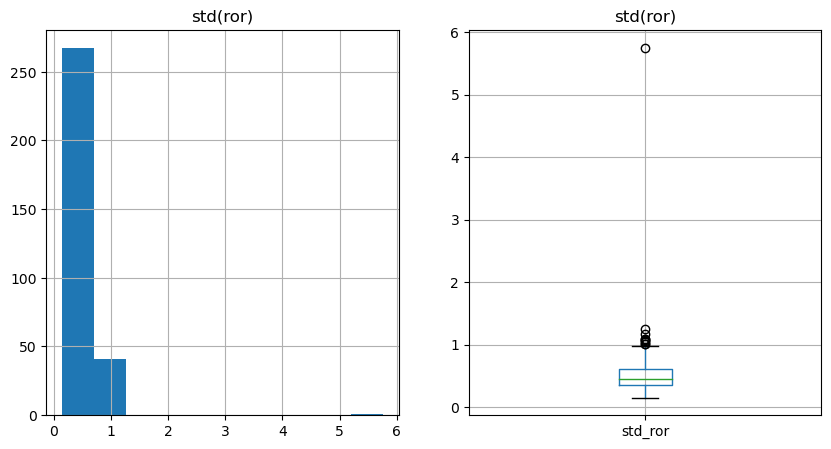

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

mask = results_df['std_ror'] < 30
results_df[mask]['std_ror'].hist(ax=ax[0])
ax[0].set_title('std(ror)')
results_df[mask].boxplot('std_ror', ax=ax[1])
ax[1].set_title('std(ror)')
plt.show()

recall the distribution of actual ror as well as the expected ror

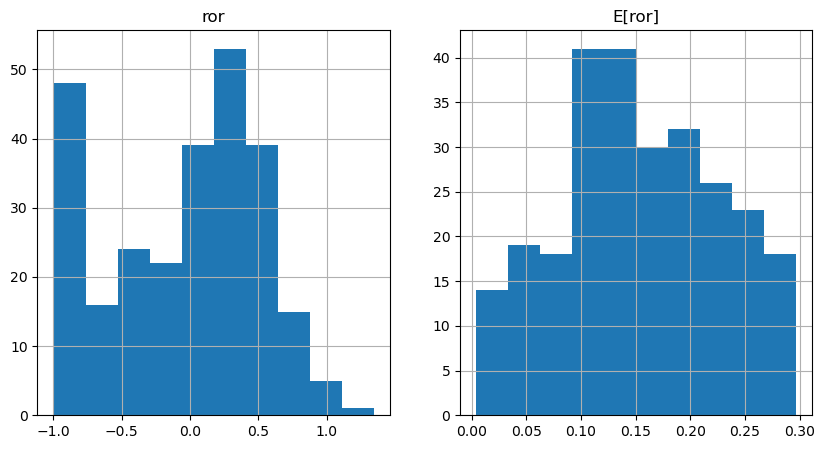

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

mask = results_df['expected_ror'] < 0.3

results_df[mask]['rate_of_return'].hist(ax=ax[0])
ax[0].set_title('ror')

results_df[mask]['expected_ror'].hist(ax=ax[1])
ax[1].set_title('E[ror]')

plt.show()

The actual distribution seems like tweedie, rather than normal while the distribution of expected profit seems to be normal. Both of the options will be tried (but only normal for now).

In [103]:
from scipy.stats import t

In [104]:
results_df['dof'] = results_df['n_games'] - 1
results_df.loc[results_df[results_df['n_games'] == 1].index, 'dof'] = 1

conf_level = 0.9
results_df[f't_{conf_level}'] = t.ppf((1+conf_level)/2, results_df['dof'])
results_df[f'lower_{conf_level}'] = results_df['expected_ror'] - results_df[f't_{conf_level}'] * results_df['std_ror'] * np.sqrt(1 + 1/results_df['dof'])
results_df[f'upper_{conf_level}'] = results_df['expected_ror'] + results_df[f't_{conf_level}'] * results_df['std_ror'] * np.sqrt(1 + 1/results_df['dof'])

In [105]:
results_df

,sharpe_ratio,rate_of_return,n_games,n_played,INT_sharpe_n_played,expected_ror,std_ror,dof,t_0.9,lower_0.9,upper_0.9
2019-01-19,0.109604,-1.000000,8,1,0.109604,0.107738,0.982974,7,1.894579,-1.883167,2.098643
2019-01-20,0.054135,-0.165000,3,2,0.108270,0.020477,0.378257,2,2.919986,-1.332260,1.373214
2019-01-21,0.361217,-0.425005,11,5,1.806086,0.179308,0.496399,10,1.812461,-0.764309,1.122925
2019-01-22,0.041161,0.580000,4,1,0.041161,0.030967,0.752353,3,2.353363,-2.013499,2.075433
2019-01-23,0.415878,-0.102113,10,5,2.079388,0.174792,0.420297,9,1.833113,-0.637336,0.986920
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06,0.664153,0.394308,7,6,3.984921,0.153177,0.230635,6,1.943180,-0.330897,0.637251
2023-02-07,2.926841,0.949485,6,2,5.853681,0.889960,0.304069,5,2.015048,0.218767,1.561154
2023-02-08,0.312993,-0.058435,10,4,1.251973,0.125319,0.400389,9,1.833113,-0.648341,0.898980
2023-02-09,0.515381,0.434336,4,3,1.546142,0.248446,0.482063,3,2.353363,-1.061527,1.558420


In [106]:
results_df['lower_0.9'].describe()

count    309.000000
mean      -1.142860
std        2.781557
min      -45.993562
25%       -1.139138
50%       -0.749286
75%       -0.530679
max        0.961781
Name: lower_0.9, dtype: float64

as the minimum possible value for ror is -1, the post-processing is applied to the lower limits

In [107]:
idx = results_df[results_df['lower_0.9']<-1].index
results_df.loc[idx, 'lower_0.9'] = -1

In [108]:
results_df['lower_0.9'].describe()

count    309.000000
mean      -0.717431
std        0.290703
min       -1.000000
25%       -1.000000
50%       -0.749286
75%       -0.530679
max        0.961781
Name: lower_0.9, dtype: float64

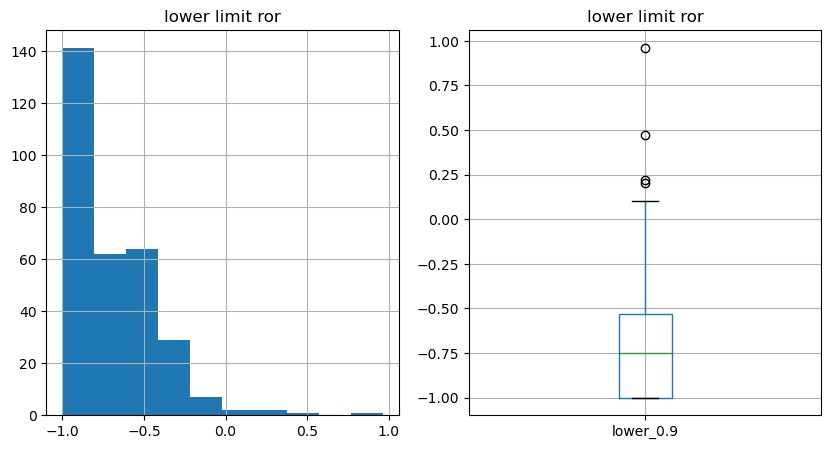

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

mask = results_df['std_ror'] < 30

results_df[mask]['lower_0.9'].hist(ax=ax[0])
ax[0].set_title('lower limit ror')
results_df[mask].boxplot('lower_0.9', ax=ax[1])
ax[1].set_title('lower limit ror')
plt.show()

lower limit tresholding

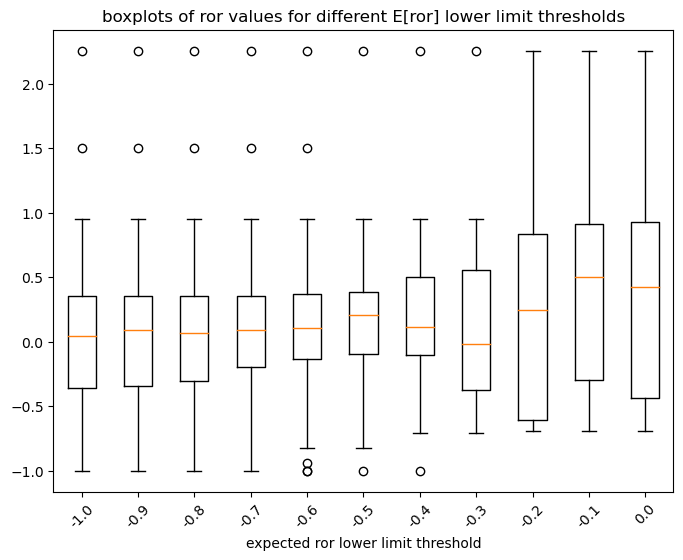

In [110]:
data = []
threshold_grid = [np.round(-1 + 0.1*i, 2) for i in range(11)]
for threshold in threshold_grid:
    mask = results_df['lower_0.9'] > threshold
    data.append(results_df[mask]['rate_of_return'])
    
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(data, labels=threshold_grid)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('expected ror lower limit threshold')
ax.set_title('boxplots of ror values for different E[ror] lower limit thresholds')
plt.show()

# model optimization

The ultimate aim of the portfolio optimization algorithm is to maximize the rate of return. Four ideas were investigated to enhance its performance in this regard:

* The relationship between sharpe ratio and the rate of return looked weak and therefore deriving some rules based on sharpe ratio was decided to be unpromising.
* On the other hand, another measure that takes both the expected value and the standard deviaton of the rate of return is prediction intervals. Though the concept of prediction intervals does not perfectly fit to the case in hand, it seemed useful to apply the idea and propose some thresholds on the lower limit of the expected rate of return.
* The model confidence did not seem strongly related with the rate of return, thus this was discarded as well.
* The number of games played was another factor that could possibly effect the overall performance of the model in a positive way.

All in all, the optimization process of the model will be run with the number of games played and the lower limit of expected rate of return. As both of these factors are post-optimization prunings/thresholdings, there will be no need to rerun the betting optimiaztion process.

In [63]:
import seaborn as sns

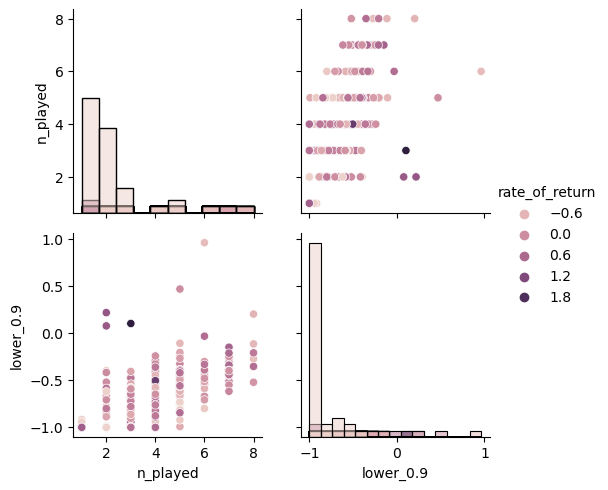

In [112]:
g = sns.PairGrid(results_df[['n_played', 'lower_0.9', 'rate_of_return']], hue='rate_of_return')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

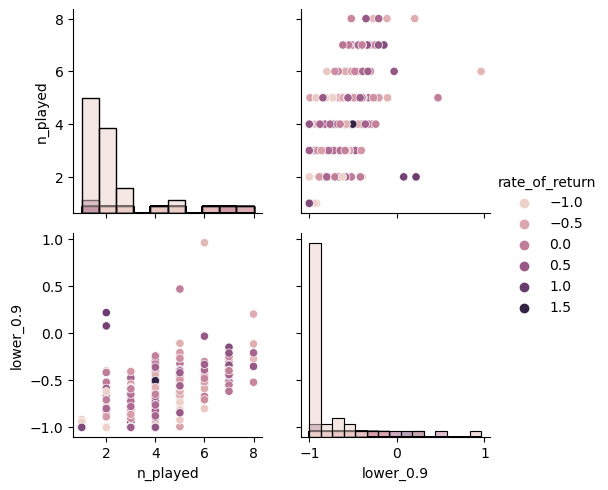

In [113]:
mask = results_df['rate_of_return'] <= 1.6

g = sns.PairGrid(results_df[mask][['n_played', 'lower_0.9', 'rate_of_return']], hue='rate_of_return')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

grid search for the best policy with respect to the cummulative rate of return

In [114]:
grid_threshold_n_played = [i for i in range(1, 8)]
grid_threshold_lower_ror = [np.round(-1 + 0.1*i, 2) for i in range(11)]
grid_logical_operator = ['and', 'or']
params_and_scores = []

for threshold_n_played in grid_threshold_n_played:
    for threshold_lower_ror in grid_threshold_lower_ror:
        for logical_operator in grid_logical_operator:
            if logical_operator == 'and':
                mask = (results_df['n_played'] >= threshold_n_played) & (results_df['lower_0.9'] >= threshold_lower_ror)
            else:
                mask = (results_df['n_played'] >= threshold_n_played) | (results_df['lower_0.9'] >= threshold_lower_ror)
            if len(results_df[mask]) < 30:
                # if the number of sample portfolios are too low, 
                # the estimation would be misleading, thus we skip them
                score = None
            else:
                # we want to take the number of portfolios accepted
                # into account as well, thus we select sum -instead of
                # mean- as the metric
                score = results_df[mask]['rate_of_return'].sum()
            params_and_scores.append([threshold_n_played, threshold_lower_ror, logical_operator, score, len(results_df[mask])])

In [115]:
params_df = pd.DataFrame(params_and_scores, 
                         columns=['min_n_played', 'min_lower_0.9', 'logical_operator', 'cumulative_ror', 'n_portfolios'])
params_df['mean_ror'] = params_df['cumulative_ror']/params_df['n_portfolios']
params_df.sort_values('cumulative_ror', ascending=False).iloc[:20]

,min_n_played,min_lower_0.9,logical_operator,cumulative_ror,n_portfolios,mean_ror
141,7,-0.6,or,9.470323,105,0.090194
30,2,-0.6,and,9.362432,104,0.090023
8,1,-0.6,and,9.362432,104,0.090023
143,7,-0.5,or,9.313702,72,0.129357
10,1,-0.5,and,9.163308,68,0.134755
32,2,-0.5,and,9.163308,68,0.134755
81,4,-0.3,or,8.846965,154,0.057448
87,4,0.0,or,8.846965,154,0.057448
83,4,-0.2,or,8.846965,154,0.057448
85,4,-0.1,or,8.846965,154,0.057448


In [116]:
def create_mask(results, params, idx):
    min_n_played, min_lower_lim, logical_op = params.loc[idx, ['min_n_played', 'min_lower_0.9', 'logical_operator']]
    if logical_op == 'and':
        return (results['n_played'] >= min_n_played) & (results['lower_0.9'] >= min_lower_lim)
    else:
        return (results['n_played'] >= min_n_played) | (results['lower_0.9'] >= min_lower_lim)

In [117]:
mask = create_mask(results_df, params_df, 141)
results_df[mask]['rate_of_return'].describe()

count    105.000000
mean       0.090194
std        0.494540
min       -1.000000
25%       -0.126941
50%        0.108285
75%        0.368227
max        2.257097
Name: rate_of_return, dtype: float64

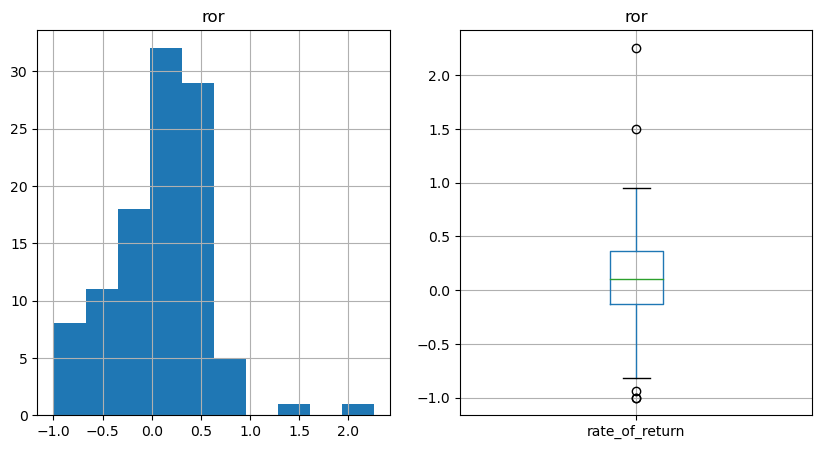

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

results_df[mask]['rate_of_return'].hist(ax=ax[0])
ax[0].set_title('ror')
results_df[mask].boxplot('rate_of_return', ax=ax[1])
ax[1].set_title('ror')
plt.show()

In [119]:
mask = create_mask(results_df, params_df, 30)

In [120]:
results_df[mask]['rate_of_return'].describe()

count    104.000000
mean       0.090023
std        0.496932
min       -1.000000
25%       -0.132071
50%        0.109813
75%        0.371270
max        2.257097
Name: rate_of_return, dtype: float64

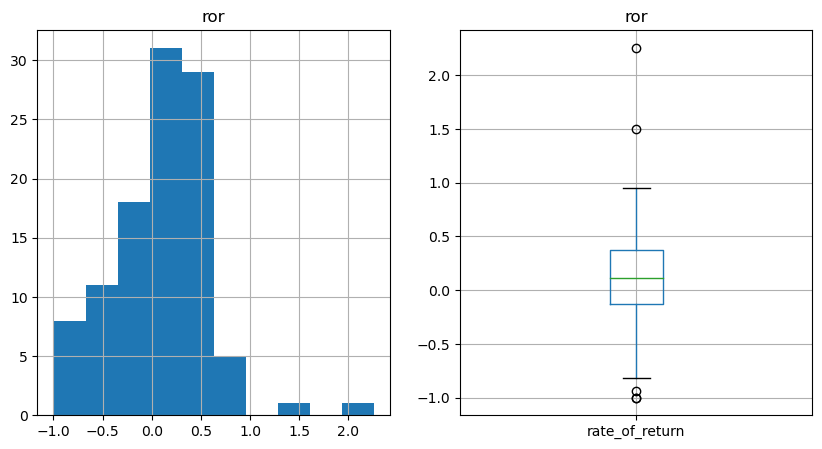

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

results_df[mask]['rate_of_return'].hist(ax=ax[0])
ax[0].set_title('ror')
results_df[mask].boxplot('rate_of_return', ax=ax[1])
ax[1].set_title('ror')
plt.show()

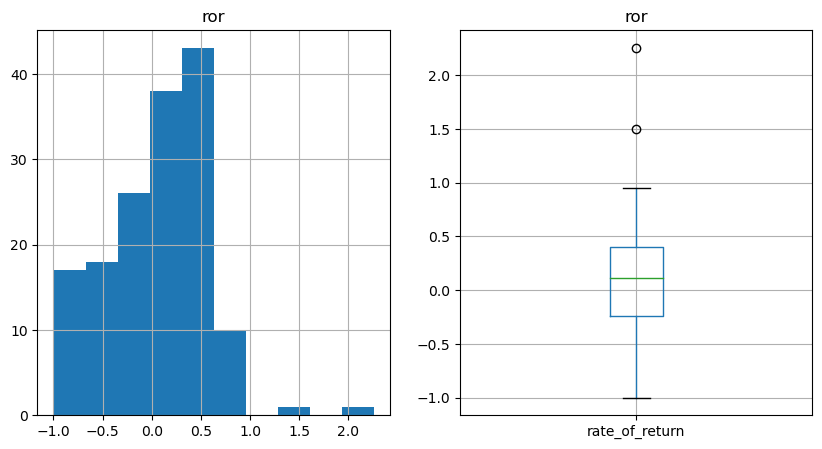

In [122]:
mask = create_mask(results_df, params_df, 81)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

results_df[mask]['rate_of_return'].hist(ax=ax[0])
ax[0].set_title('ror')
results_df[mask].boxplot('rate_of_return', ax=ax[1])
ax[1].set_title('ror')
plt.show()

In [123]:
params_df.sort_values('cumulative_ror', ascending=False).iloc[:10]

,min_n_played,min_lower_0.9,logical_operator,cumulative_ror,n_portfolios,mean_ror
141,7,-0.6,or,9.470323,105,0.090194
30,2,-0.6,and,9.362432,104,0.090023
8,1,-0.6,and,9.362432,104,0.090023
143,7,-0.5,or,9.313702,72,0.129357
10,1,-0.5,and,9.163308,68,0.134755
32,2,-0.5,and,9.163308,68,0.134755
81,4,-0.3,or,8.846965,154,0.057448
87,4,0.0,or,8.846965,154,0.057448
83,4,-0.2,or,8.846965,154,0.057448
85,4,-0.1,or,8.846965,154,0.057448


In [124]:
rules = []
cols = ['min_n_played', 'min_lower_0.9', 'logical_operator']
for _, row in params_df.sort_values('cumulative_ror', ascending=False).iloc[:10].iterrows():
    rule = {col:row[col] for col in cols}
    rules.append(rule)
rules

[{'min_n_played': 7, 'min_lower_0.9': -0.6, 'logical_operator': 'or'},
 {'min_n_played': 2, 'min_lower_0.9': -0.6, 'logical_operator': 'and'},
 {'min_n_played': 1, 'min_lower_0.9': -0.6, 'logical_operator': 'and'},
 {'min_n_played': 7, 'min_lower_0.9': -0.5, 'logical_operator': 'or'},
 {'min_n_played': 1, 'min_lower_0.9': -0.5, 'logical_operator': 'and'},
 {'min_n_played': 2, 'min_lower_0.9': -0.5, 'logical_operator': 'and'},
 {'min_n_played': 4, 'min_lower_0.9': -0.3, 'logical_operator': 'or'},
 {'min_n_played': 4, 'min_lower_0.9': 0.0, 'logical_operator': 'or'},
 {'min_n_played': 4, 'min_lower_0.9': -0.2, 'logical_operator': 'or'},
 {'min_n_played': 4, 'min_lower_0.9': -0.1, 'logical_operator': 'or'}]

In [125]:
rules2 = {'headers':cols,
          'values':{i:[v for v in rules[i].values()] for i in range(len(rules))}}
rules2

{'headers': ['min_n_played', 'min_lower_0.9', 'logical_operator'],
 'values': {0: [7, -0.6, 'or'],
  1: [2, -0.6, 'and'],
  2: [1, -0.6, 'and'],
  3: [7, -0.5, 'or'],
  4: [1, -0.5, 'and'],
  5: [2, -0.5, 'and'],
  6: [4, -0.3, 'or'],
  7: [4, 0.0, 'or'],
  8: [4, -0.2, 'or'],
  9: [4, -0.1, 'or']}}

In [126]:
# with open('preds_with_bet_ratios', 'wb') as f:
#     _pickle.dump(preds, f)